**Задание:**
1. Реализовать метод стохастического градиента для обучения линейных алгоритмов классификации.
2. Методом стохастического градиента обучить один из линейных алгоритмов классификации (ADALINE, Правило Хебба, Логистическая регрессия) на первых двух классах выборки ирисов Фишера (выборка в приложении `iris_cropped.json`).
3. С помощью обученного алгоритма построить разделяющую прямую между этими классами, и отобразить классы и прямую на графике (см. пример для случайных данных в приложении `linear_classifier.png`).

**Метод стохастического градиента**

Даны $X$ и $Y = \{-1, +1\}$

$a(x, w) = sign (<w,x> - \, w_0) = sign \left(\sum\limits_{j = 1}^n f_j(x) * w_j - w_0\right)$


Смысл метода заключается в том, что сначала выбирается начальное приближение вектора $w$, а затем на каждом шаге он улучшается в направлении наиболее быстрого убывания $Q$.

Алгоритм:

1) Инициализация начального приближения $w$. Например, $random\left(-\frac{1}{2*n}, \frac{1}{2*n}\right)$.

2) $Q = \sum\limits_{i = 1}^l L(<w, x_i> y_i)$

3.1) Выбрать объект $x_i$

3.2) $\varepsilon _i = L(<w, x_i> y_i)$.

3.3) $w = w - \eta L'(<w, x_i> y_i) x_i y_i$.

3.4) $Q = (1 - \lambda) Q + \lambda \varepsilon_i$.

3.5) Повторять шаг 3 пока изменяются $Q$ и/или $w$.

**Метод ADALINE**

Возьмем $L(M) = (M - 1)^2$.

Для нее $L'(M) = 2(<w, x_i> y_i) x_i$.

Получаем правило обновления весов $w = w - \eta (<w, x_i> y_i) x_i$.

In [62]:
import numpy as np
import pandas as pd

class LinearBinaryClassifier:
  X: pd.DataFrame
  y: pd.Series
  w: np.ndarray
  bias: float

  def __init__(self, X, y):
    self.X = X
    self.X['bias'] = np.ones(len(X))
    self.y = y

  @property
  def size(self):
    return len(self.X)

  @property
  def columns(self):
    return len(self.X.iloc[0])

  @staticmethod
  def loss_function(predicted, needed):
    return (predicted * needed - 1)**2

  def update(self, predicted, needed, obj, learning_rate):
    self.w -= learning_rate * (predicted - needed) * obj

  def predict(self, obj):
    fx = np.sum(obj * self.w)
    return np.sign(fx), fx

  def calc_loss(self):
    return sum(
      self.loss_function(np.dot(obj, self.w), obj_class)
      for obj, obj_class in zip(self.X.values, self.y.values)
    )

  def stochastic_gradient(self, lmbda, learning_rate, break_when_no_errors=True):
    self.w = np.random.uniform(-1 / (2 * self.columns), 1 / (2 * self.columns), self.columns)
    self.bias = np.random.uniform(-1 / (2 * self.columns), 1 / (2 * self.columns))
    cur_loss = self.calc_loss()

    for step in range(1, 30000):
      errors = [i for i in range(self.size) if np.dot(self.X.values[i], self.w) * self.y.values[i] < 0]
      if len(errors) == 0 and break_when_no_errors:
        break

      ind = np.random.randint(self.size) if len(errors) == 0 else errors[np.random.randint(len(errors))]
      x = self.X.values[ind]
      y = self.y.values[ind]
      fx = np.dot(x, self.w) * y

      eps = self.loss_function(fx, y)
      self.update(fx, y, x, learning_rate)
      loss = (1 - lmbda) * cur_loss + lmbda * eps
      if abs(loss - cur_loss) < 0.0001:
        return

      cur_loss = loss

Загрузим выборку ирисов Фишера, классифицировать будем первые два класса. Для наглядности выберем первые два признака.

In [66]:
import json
import pandas as pd

with open('iris_cropped.json') as f:
  iris_dict = json.loads(f.read())

df = pd.DataFrame(iris_dict, columns=["x", "y", "ans"])
X = df[['x', 'y']]
y = df[['ans']].iloc[:, 0].replace(to_replace=0, value=-1)

In [69]:
adaline = LinearBinaryClassifier(X, y)
adaline.stochastic_gradient(0.01, 0.01)

ADALINE успешно разделяет два класса из ирисов фишера

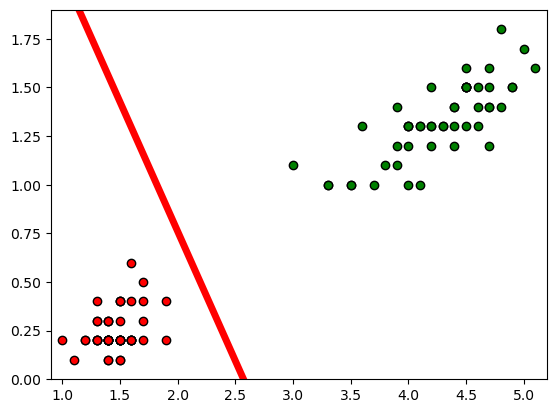

In [70]:
from matplotlib import pyplot as plt
STEP = 0.1
x = np.linspace(X['x'].min(), X['x'].max(), 100)

plt.plot(x, (-adaline.w[2] - adaline.w[0] * x) / adaline.w[1], color="red", linewidth=5)

color = {1: 'green', -1: 'red'}

for ind in range(adaline.size):
  plt.scatter(
    adaline.X['x'].values[ind],
    adaline.X['y'].values[ind],
    color=color[adaline.y.values[ind]],
    edgecolors='black',
    zorder=10
  )

plt.xlim(X['x'].min() - STEP, X['x'].max() + STEP)
plt.ylim(X['y'].min() - STEP, X['y'].max() + STEP)
plt.show()